# A pendulum video and autoencoder


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import sys
syspath = 'SindyPendulum/'
if syspath not in sys.path:
    sys.path.append(syspath)

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


# Data Generation

In [5]:
#!git clone https://github.com/pietro-sillano/SindyPendulum.git

In [4]:
#!cd SindyPendulum && git pull

In [3]:
from sindy_library import SINDyLibrary

In [6]:
#!python SindyPendulum/data_pendulum_image.py  -i 60

In [3]:
import os
import argparse, sys
import numpy as np
from scipy.integrate import odeint

def pend(y, t,):
    theta, omega = y
    dydt = [omega, - np.sin(theta)]
    return dydt

def pend_damp(y, t,):
    theta, omega = y
    dydt = [omega, - np.sin(theta)-0.1*omega]
    return dydt

def select_ics(theta0,omegaics0):
    ics = []
    for i in range(n_ics):
        for j in range(n_ics):
            lim = (np.abs((omega0[j]**2)/2 - np.cos(theta0[i])))
            if lim <  0.99 :
                ics.append((theta0[i],omega0[j]))
    return ics

def wrap_to_pi(z):
    z_mod = z % (2*np.pi)
    subtract_m = (z_mod > np.pi) * (-2*np.pi)
    return z_mod + subtract_m

def image_gen(ics):
    x = np.linspace(-1.5, 1.5, NX)
    y = np.linspace(-1.5, 1.5, NY)
    xx,yy = np.meshgrid(x, y)


    data = np.empty([len(ics), len(t), len(x), len(y)],dtype = np.float32)
    data2 = np.empty([len(ics), len(t), len(x), len(y)],dtype = np.float32)


    for idx in range(len(ics)):
        if(idx%100==0): print(idx,' su ', len(ics))
        y0 = [ics[idx][0], ics[idx][1]]
        sol = odeint(pend, y0,t)
        theta = sol[:,0]
        omega = sol[:,1]

        temp = []
        for i in range(len(theta)):
            z = np.exp(- 20 *((xx - np.cos(theta[i] + np.pi/2))*(xx - 
                np.cos(theta[i] +np.pi/2))) - 20 * ((yy -np.sin(theta[i]+np.pi/2))*(yy -np.sin(theta[i]+np.pi/2))))
            z = ((z - np.min(z))/(np.max(z)-np.min(z)))
    
            temp.append(z)
        data[idx] = np.array(temp)
        
        temp = []
        for i in range(len(omega)):
            #exp = np.exp(- 20 *((xx - np.cos(omega[i] + np.pi/2))*(xx - 
            #    np.cos(omega[i] +np.pi/2))) - 20 * ((yy -np.sin(omega[i]+np.pi/2))*(yy -np.sin(omega[i]+np.pi/2))))

            #z = -20*(2*(xx - np.cos(theta[i]-np.pi/2))*np.sin(theta[i]-np.pi/2)*omega[i] 
            #            + 2*(yy - np.sin(theta[i]-np.pi/2))*(-np.cos(theta[i]-np.pi/2))*omega[i])
            #z = z*exp
            #z = ((z - np.min(z))/(np.max(z)-np.min(z)))
            
            exp = 2 * omega[i]*(np.cos(theta[i]+ np.pi/2) - np.sin(theta[i] + np.pi/2))
            z = np.exp(- 20 *((xx - np.cos(theta[i] + np.pi/2))*(xx - 
                np.cos(theta[i] +np.pi/2))) - 20 * ((yy -np.sin(theta[i]+np.pi/2))*(yy -np.sin(theta[i]+np.pi/2))))
            z = z * exp
            z = ((z - np.min(z))/(np.max(z)-np.min(z)))
            temp.append(z)
        data2[idx] = np.array(temp)
        
    return data,data2

In [4]:
n_ics=50
    
#COSTANTI e PARAMETRI
ta = 0.
tb = 5.
dt = 0.05  
# tb = 10
# dt = 0.1
NX = 51
NY = 51


t = np.arange(ta, tb ,dt)
theta0 = np.linspace(-np.pi,np.pi,n_ics)
omega0 = np.linspace(-2.1, 2.1,n_ics)

ics = select_ics(theta0,omega0)
data,data2 = image_gen(ics)


#questo reshape serve per mandare al autoencoder delle immagini flat
#TODO verifica che sia corretto questo rehsape --> dovrebb essere ok fatto prova su colab
data = data.reshape((len(ics) * len(t),NX * NY))
data2 = data2.reshape((len(ics) * len(t),NX * NY))

X = data
Xdot = data2


0  su  1432
100  su  1432
200  su  1432
300  su  1432
400  su  1432
500  su  1432
600  su  1432
700  su  1432
800  su  1432
900  su  1432
1000  su  1432
1100  su  1432
1200  su  1432
1300  su  1432
1400  su  1432


In [ ]:
import ipyparallel as ipp

cluster = ipp.Cluster.from_file("/home/jupyter-psillano/.ipython/profile_default/security/cluster-.json")
rc = cluster.connect_client_sync()
rc

In [ ]:
import ipyparallel as ipp

cluster = ipp.Cluster.from_file("/home/jupyter-psillano/.ipython/profile_default/security/cluster-.json")
rc = cluster.connect_client_sync()
rc

In [ ]:
import ipyparallel as ipp

cluster = ipp.Cluster.from_file("/home/jupyter-psillano/.ipython/profile_default/security/cluster-.json")
rc = cluster.connect_client_sync()
rc

In [10]:
#X = np.load('./X.npy')
#Xdot = np.load('./Xdot.npy')

In [6]:
X = torch.from_numpy(X).float().to(device)
Xdot = torch.from_numpy(Xdot).float().to(device)
X.shape, Xdot.shape, X.dtype

(torch.Size([143200, 2601]), torch.Size([143200, 2601]), torch.float32)

In [7]:
val_size = round(X.shape[0] * 0.1)
train_size = X.shape[0] - val_size
train_size, val_size

(128880, 14320)

In [8]:
batch_size = 1024
my_dataset = TensorDataset(X,Xdot)
#dataloader = DataLoader(my_dataset,batch_size=batch_size, shuffle=True)

In [9]:
train_subset, val_subset = torch.utils.data.random_split(my_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, shuffle=True, batch_size=batch_size)
val_loader   = DataLoader(val_subset, shuffle=False, batch_size=batch_size)

# Network




In [10]:
class Encoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc4 = nn.Linear(128,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=False,
            include_states=True,
            include_sin=True,
            include_cos=True,
            include_multiply_pairs=False,
            poly_order=1,
            include_sqrt=False,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)
        

        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1,dtype = torch.float32,requires_grad=True,device = device))

        self.XI_coefficient_mask = torch.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = torch.float32, device=device)

    def configure_optimizers(self):
        learning_rate = 1e-4
 #       return torch.optim.SGD(self.parameters(), lr=0.1)
        return torch.optim.Adam(self.parameters(), lr=learning_rate)


    def t_derivative(self,input, xdot, weights, biases, activation='sigmoid'):
        """
        Compute the first order time derivatives by propagating through the network.
        da[l]dt = xdot * da[l]dx = xdot * product(g'(w[l]a[l-1] + b[l])* w[l])
        Arguments:
            input - 2D tensorflow array, input to the network. Dimensions are number of time points
            by number of state variables.
            xdot - First order time derivatives of the input to the network. quello che conosciamo
            weights - List of tensorflow arrays containing the network weights
            biases - List of tensorflow arrays containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu' (exponential linear unit), 'relu' (rectified linear unit), 'sigmoid',
            or linear.

        Returns:
            dadt - Tensorflow array, first order time derivatives of the network output.
        """
        a   = input
        dadt = xdot #per le condizioni iniziali

        if activation == 'sigmoid':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.sigmoid(z)
                gprime = a * (1-a)
                dadt = gprime * torch.matmul(dadt, weights[i].T)
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            
        elif activation == 'relu':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.relu(z)
                dadt = (z > 0).float() * torch.matmul(dadt, weights[i].T)    
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
        return dadt #nel caso che ci serve dadt sará l output dell encoder ossia le latent variables!

    
    
    def compute_quantities(self,x,xdot):
    
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='relu')                                               

        #print("propagazione sul decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot = self.t_derivative(z, zdot_hat, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        if(DEBUG == True):
            print('z',z)
            print(' xtilde',xtilde)
            print('theta',theta)
            print('max theta',theta.max())
            print('zdot',zdot)
            print('zdothat',zdot_hat)
            print('xtildedot',xtildedot)
        return xtilde, xtildedot, z, zdot, zdot_hat

    def loss_function(self, x, xdot, xtilde, xtildedot, zdot, zdot_hat,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5
        #alpha1 = 5e-3
        #alpha2 = 5e-4
        #alpha3 = 1e-4
        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zdot, zdot_hat) 
        loss['sindy_regular_loss'] = torch.sum(torch.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_x'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    def forward(self, x, xdot):
        return self.compute_quantities(x, xdot)

In [11]:
input_size = X.shape[1]
latent_dim = 2

In [20]:
model = Autoencoder(input_size,latent_dim).to(device)

Encoder(
  (fc1): Linear(in_features=2601, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
)
Linear(in_features=2601, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=2, bias=True)


In [21]:
model.SINDyLibrary.number_candidate_functions

6

# Parameters and Training


In [22]:
def sequential_threshold(t):
    if (t % 100 == 0 and t>1):
        model.XI_coefficient_mask = torch.abs(model.XI) > 0.01
        print_model()

In [23]:
def print_model():
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    for j in range(latent_dim):
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]
            if  coeff !=0:
                print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
        print()

In [26]:
epochs = 1000
DEBUG = False
VALIDATION = True
SAVE = True
path = '../model'


loss_list = {}
loss_list['recon_loss'] = []
loss_list['sindy_loss_x'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
#loss_list['validation'] = []
loss_list['tot'] = []
loss_val_list = []


for t in range(epochs):
    #start = time.time()
    
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    #loss_epoch['validation'] = []
    loss_epoch['tot'] = []
    loss_val_epoch = []
    
    model.train()
    for batch, (X,Xdot) in enumerate (train_loader):
        X.to(device) #per passarlo alla gpu
        Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)

        # Backpropagation
        optimizer = model.configure_optimizers()
        loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss.backward()
        del  xtilde, xtildedot, z, zdot, zdot_hat,loss
        optimizer.step()
        optimizer.zero_grad()

        current = batch * len(X)

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        del loss_dict

    for key in loss_epoch.keys():
        loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
    del loss_epoch
    
    
    #validation step
    if VALIDATION == True:
        model.eval()     # Optional when not using Model Specific layer
        for batch, (X,Xdot) in enumerate (val_loader):
            X.to(device) #per passarlo alla gpu
            Xdot.to(device)
            #forward pass 
            xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)
            # validation loss 
            loss, _ = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
            loss_val_epoch.append(loss.item())
            del  xtilde, xtildedot, z, zdot, zdot_hat,loss
        
        loss_val_list.append(sum(loss_val_epoch)/len(loss_val_epoch))

    #end = time.time()
    if t % 20 == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')
        #print(f'val loss of epoch {t}: {loss_val_list[-1]:.3e}')
        #print('time: ',end-start)
        
    if SAVE == True:
        if t % 100 ==0 and t>1 and loss_val_list[t] < loss_val_list[t-1]:
            f1 = path + './model'+str(batch_size)+'_'+str(t)+'epochs'+'.pt'
            torch.save(model,f1)
            print('salvato il',f1)

print("Done!")


Epoch 0
-------------------------------
recon_loss of epoch 0: 6.876e-04
sindy_loss_x of epoch 0: 2.833e-01
sindy_loss_z of epoch 0: 1.978e-01
sindy_regular_loss of epoch 0: 5.150e-01
tot of epoch 0: 8.443e-04


KeyboardInterrupt: 

In [27]:
coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
XI = model.XI.cpu().detach().numpy()
feature_list = model.SINDyLibrary.get_feature_names()

print_model()

dz0 = 0.2345 z0
dz0 = 0.0145 z1
dz0 = 0.0001 sin(z0)
dz0 = 0.0001 sin(z1)
dz0 = 0.0001 cos(z0)

dz1 = 0.0475 z0
dz1 = 0.1984 z1
dz1 = 0.0001 sin(z0)
dz1 = 0.0001 sin(z1)
dz1 = 0.0000 cos(z0)



Text(0.5, 1.0, 'Loss con batch size di 1024')

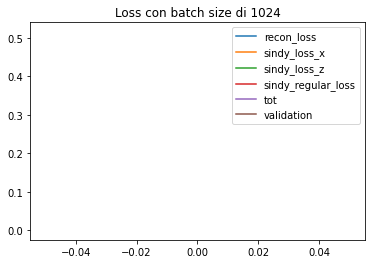

In [28]:
import pandas as pd
data = pd.DataFrame.from_dict(loss_list)
data.to_csv('./data'+str(batch_size)+'_'+str(t)+'epochs'+'.csv')
torch.save(model,'./model'+str(batch_size)+'.pt')
for key in loss_list.keys():
    plt.plot(loss_list[key],label = key)
plt.plot(loss_val_list,label = 'validation')    
plt.legend(loc = 'best')
plt.title('Loss con batch size di '+str(batch_size))

In [ ]:
plt.semilogy(loss_val_list)
plt.loglog(loss_list['tot'])